In [224]:
import sys
sys.path.append('../lib')
from table_detection import Signal, LineDetection, Table
import cv2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
signal = np.zeros(1000)

In [5]:
signal[[200,300,700]] = 1

In [6]:
signal += 0.005*np.random.randn(1000)

In [7]:
import matplotlib.pyplot as plt

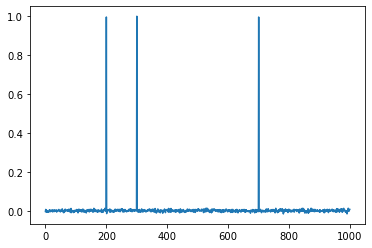

In [8]:
plt.plot(signal)

In [9]:
sgnl = Signal(signal)

In [10]:
sgnl.find_peaks(distance=15)

array([200, 300], dtype=int64)

In [11]:
img = 255*(plt.imread('../results/test_column_mask/3258563200475.nutrition.jpg')<30)

In [12]:
line_detect = LineDetection(img,(512,512))

In [13]:
line_detect.find_peaks(15,10,0)

In [14]:
line_detect.signal.find_peaks()

array([162], dtype=int64)

In [78]:
def get_sub_mask_by_removing_overfilled_borders(mask,axis):
    mask_summed_on_axis = mask.sum(axis=axis)
    indexes = np.where(mask_summed_on_axis>mask_summed_on_axis.max()*0.8)[0]
    start, end = get_biggest_gap_index(indexes)
    if axis == 1:
        mask[:start]=0
        mask[end:] = 0
    elif axis == 0:
        mask[:, :start]=0
        mask[:, end:] = 0
    return mask

In [215]:
def column_process_mask(mask):
    # Définir le pas du kernel >20 pour que les lignes verticales soient plus accentuées 
    
    #close horizontal thin lines
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
    
    #get the inverse of the 
    result = (255*(close<128)).astype(np.uint8)
    
    #dilate then erode to connect "broken lines"
    kernel = np.ones((20,1), np.uint8)  # note this is a horizontal kernel
    d_im = cv2.dilate(result, kernel, iterations=1)
    e_im = cv2.erode(d_im, kernel, iterations=1)
    
    #overfilled lines borders are removed
    processed_mask = get_sub_mask_by_removing_overfilled_borders(e_im,axis=1)
    
    return processed_mask

In [79]:
def line_process_mask(mask):
    empty_mask = np.zeros((mask.shape),np.uint8)
    # Définir le pas du kernel >20 pour que les lignes verticales soient plus accentuées 
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,1))
    close = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel1)
    close = np.logical_or(close,mask).astype('uint8')
    div = np.float32(mask)/(close)
    
    kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(5,1))
    dx = cv2.Sobel(div,cv2.CV_16S,1,0)
    dx = cv2.convertScaleAbs(dx)
    cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
    ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return get_sub_mask_by_removing_overfilled_borders(close,axis=0)

In [164]:
mask = cv2.cvtColor(plt.imread('../results/test_column_mask/3269210251580.nutrition.jpg'),cv2.COLOR_RGB2GRAY)

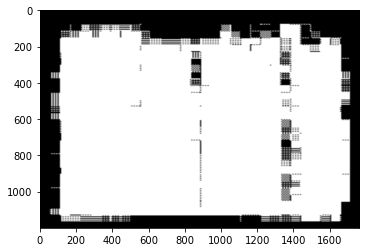

In [149]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,2))
close = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel1)
div = np.float32(mask)/(close)
plt.imshow(close,cmap='gray')
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

close = np.logical_or(close,mask).astype('uint8')
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,10))
close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
div = np.float32(mask)/(close)


dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)

#
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#close = cv2.morphologyEx(close,cv2.MORPH_DILATE,kernely,iterations = 1)

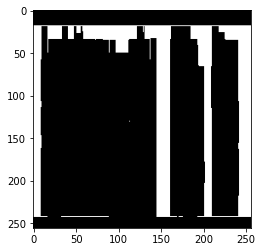

In [218]:
plt.imshow(column_process_mask(mask),cmap='gray')

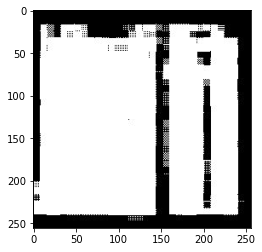

In [166]:
plt.imshow(mask,cmap='gray')

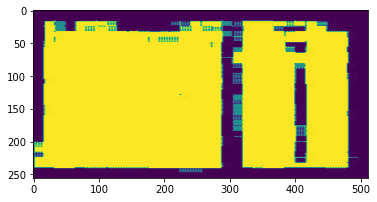

In [250]:
plt.imshow(cv2.resize(mask,(512,256)))

In [260]:
def process_line_mask(mask):
    
    #close vertical thin lines
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,5))
    close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
    
    #get the inverse of the 
    result = (255*(close<128)).astype(np.uint8)
    
    #dilate then erode to connect "broken lines"
    kernel = np.ones((1,20), np.uint8)  # note this is a horizontal kernel
    d_im = cv2.dilate(result, kernel, iterations=1)
    e_im = cv2.erode(d_im, kernel, iterations=1)
    
    #overfilled lines borders are removed
    processed_mask = get_sub_mask_by_removing_overfilled_borders(e_im,axis=0)
    
    return processed_mask

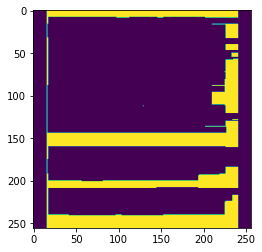

In [261]:
plt.imshow(process_line_mask(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE)))

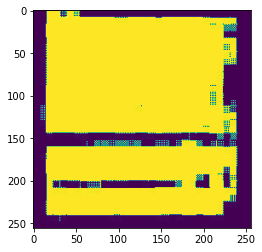

In [262]:
plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE))

In [269]:
table = Table(mask,cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE),(512,512))

In [270]:
table.find_columns()

In [271]:
table.find_table()

In [272]:
table.table

[[Rectangle(xmin=0, ymin=0, xmax=296, ymax=302),
  Rectangle(xmin=0, ymin=302, xmax=296, ymax=402),
  Rectangle(xmin=0, ymin=402, xmax=296, ymax=512)],
 [Rectangle(xmin=296, ymin=0, xmax=392, ymax=302),
  Rectangle(xmin=296, ymin=302, xmax=392, ymax=402),
  Rectangle(xmin=296, ymin=402, xmax=392, ymax=512)],
 [Rectangle(xmin=392, ymin=0, xmax=512, ymax=302),
  Rectangle(xmin=392, ymin=302, xmax=512, ymax=402),
  Rectangle(xmin=392, ymin=402, xmax=512, ymax=512)]]

In [ ]:
plt.imshow()

In [236]:
def runningMean(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

In [237]:
runningMean(column_process_mask(mask).sum(axis=0),25)

array([22909.2, 20777.4, 18645.6, 16513.8, 14382. , 12250.2, 10118.4,
        7986.6,  5854.8,  3733.2,  3111. ,  3111. ,  3111. ,  3111. ,
        3111. ,  3111. ,  3111. ,  3264. ,  3111. ,  3121.2,  3131.4,
        3141.6,  3151.8,  3162. ,  3019.2,  2876.4,  2733.6,  2672.4,
        2611.2,  2550. ,  2488.8,  2427.6,  2284.8,  2142. ,  2050.2,
        2203.2,  2356.2,  2509.2,  2662.2,  2815.2,  2968.2,  3121.2,
        3121.2,  3121.2,  3121.2,  3121.2,  3121.2,  3121.2,  3121.2,
        3284.4,  3437.4,  3590.4,  3661.8,  3733.2,  3804.6,  3876. ,
        3947.4,  4100.4,  4263.6,  4365.6,  4375.8,  4386. ,  4396.2,
        4406.4,  4416.6,  4569.6,  4569.6,  4569.6,  4569.6,  4569.6,
        4569.6,  4569.6,  4569.6,  4722.6,  4865.4,  5018.4,  5171.4,
        5324.4,  5477.4,  5630.4,  5783.4,  5936.4,  6089.4,  6232.2,
        6375. ,  6517.8,  6660.6,  6803.4,  6793.2,  6783. ,  6619.8,
        6609.6,  6599.4,  6589.2,  6579. ,  6568.8,  6558.6,  6548.4,
        6232.2,  591

In [4]:
import pandas as pd

In [5]:
base_path = 'C:\\Users\\sadok.guermazi\\Documents\\Projects\\Open Food Facts' 

In [6]:
import os
import cv2
from urllib.request import urlopen
import matplotlib.pyplot as plt
import numpy as np
import json
import re
from shapely.geometry import Point
from shapely.geometry import LineString

In [7]:
df = pd.read_csv(os.path.join(base_path,'dump.csv'),encoding='utf8')

In [8]:
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = np.array(image, dtype=np.int64)
    return image

In [8]:
def convert_to_dict(string):
    return json.loads(string.replace("\'", "\"").replace('None','null'))

In [27]:
annotation_folder = '../data/'

In [28]:
if os.path.exists(annotation_folder)==False:
    os.mkdir(annotation_folder)

In [29]:
url_prefix = 'https://static.openfoodfacts.org/images/products'
source_images = [url_prefix+x for x in df['source_image'].tolist()]

In [30]:
im_num=1

In [31]:
crop = {'end': {'x': 569, 'y': 279},
         'start': {'x': 10, 'y': 10},
         'currentlyDragged': None}

{'end': {'x': 569, 'y': 279},
 'start': {'x': 10, 'y': 10},
 'currentlyDragged': None}

In [32]:
crop = convert_to_dict(df.data.iloc[im_num])['annotation']['crop']
pt1 = (crop['start']['x'],crop['start']['y'])
pt2 = (crop['end']['x'],crop['end']['y'])
img = url_to_image(source_images[im_num])
cropped_image = img[pt1[1]:pt2[1]][pt1[0]:pt2[0]]
image_id = str(df.barcode.iloc[im_num])+'.nutrition'
plt.imsave(os.path.join(annotation_folder,image_id+'_cropped.jpg'),cropped_image.astype(np.uint8))

In [ ]:
n_compromised_images=0
from tqdm import tqdm
for im_num,_ in tqdm(enumerate(source_images)):
    try:
        crop = convert_to_dict(df.data.iloc[im_num])['annotation']['crop']
        pt1 = (max(crop['start']['x'],0),max(crop['start']['y'],0))
        pt2 = (max(crop['end']['x'],0),max(crop['end']['y'],0))
        if pt1[0]>pt2[0]:
            a=pt1
            pt1=pt2
            pt2=a
        img = url_to_image(source_images[im_num])
        cropped_image = img[pt1[1]:pt2[1],pt1[0]:pt2[0]]
        image_id = str(df.barcode.iloc[im_num])+'.nutrition'
        plt.imsave(os.path.join(annotation_folder,image_id+'_cropped.jpg'),cropped_image.astype(np.uint8))
    except ValueError:
        print('image n°{} failed to load annotation'.format(im_num))
        n_compromised_images+=1
print(n_compromised_images)

In [189]:
df.barcode.iloc[im_num]

3478920030839

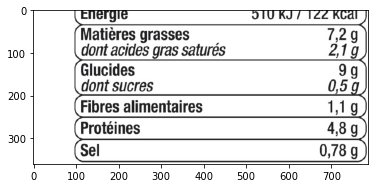

In [180]:
plt.imshow(img[pt1[1]:pt2[1]][pt1[0]:pt2[0]])

In [79]:
df.data.iloc[im_num].replace("\'", "\"").replace(' None','null')[90:110]

'ntlyDragged":null}, '

In [68]:
p.sub('\"', df.data.iloc[im_num])[90:110]

'ntlyDragged": None},'

In [20]:
path = '../data/3104935391275.nutrition_cropped.jpg'
img = plt.imread(path)

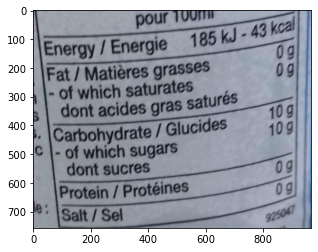

In [21]:
plt.imshow(img)

In [45]:
def get_angle(vertices):
    pt3 = vertices[2]
    pt4 = vertices[3]
    x3 = pt3['x']
    x4 = pt4['x']
    y3 = pt3['y']
    y4 = pt4['y']
    adj = abs(x3-x4)
    hyp = np.sqrt((x3-x4)**2 + (y3-y4)**2)
    return np.sign(y3-y4)*np.arccos(adj/hyp)

In [46]:
annot = convert_to_dict(df[df.barcode==3023260024781]['data'].iloc[0])['annotation']
angles = [get_angle(x['boundingPoly']['vertices']) for x in list(annot['textAnnotations'].values()) if x['cell_id'] is not None]*90
best_angle = np.mean([get_angle(x['boundingPoly']['vertices']) for x in list(annot['textAnnotations'].values()) if x['cell_id'] is not None])*180/np.pi
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, \
          borderMode=cv2.BORDER_REPLICATE)

error: C:\ci\opencv_1512688052760\work\modules\imgproc\src\imgwarp.cpp:1825: error: (-215) ifunc != 0 in function cv::remap


In [142]:
def get_circumscribed_rectangle(vertices):
    
    pt1 = Point(vertices[0]['x'],vertices[0]['y'])
    pt2 = (vertices[1]['x'],vertices[1]['y'])
    pt3 = (vertices[2]['x'],vertices[2]['y'])
    pt4 = Point(vertices[3]['x'],vertices[3]['y'])
    
    dist1 = LineString([pt2,pt3]).project(pt1)
    projected_pt1 = list(LineString([pt2,pt3]).interpolate(dist1).coords)[0]
    vertices[1] = {'x':round(projected_pt1[0]),'y':round(projected_pt1[1])}
    print("Point: {}".format(pt2))
    print("New Point: {}".format(vertices[1]))
    
    dist4 = LineString([pt2,pt3]).project(pt4)
    projected_pt4 = list(LineString([pt2,pt3]).interpolate(dist4).coords)[0]
    vertices[2] = {'x':round(projected_pt4[0]),'y':round(projected_pt4[1])}
    print("Point: {}".format(pt3))
    print("New Point: {}".format(vertices[2]))
    return vertices

In [143]:
vertices_list = [x['boundingPoly']['vertices'] for x in list(annot['textAnnotations'].values()) if x['cell_id'] is not None]

In [78]:
point = Point(50, 50)
dist = LineString([(0, 100), (100, 120)]).project(point)
list(LineString([(0, 100), (100, 120)]).interpolate(dist).coords)

[(38.46153846153847, 107.6923076923077)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


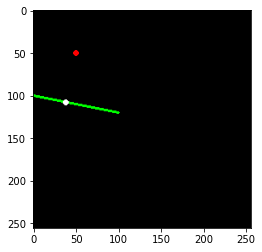

In [80]:
blank = np.zeros((256,256,3))
blank = cv2.line(blank,(0, 100), (100, 120),color=(0,255,0),thickness=2)
blank = cv2.circle(blank, (50,50), color=(255,0,0),radius=2,thickness=2)
blank = cv2.circle(blank, (round(38.46153846153847), round(107.6923076923077)), color=(255,255,255),radius=2,thickness=2)
plt.imshow(blank)

## OFF Image Class

In [544]:
from collections import namedtuple
import cv2
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

In [ ]:
with open(os.path.join(ocr_folder_path,file+'.json')) as json_file:
        data = json.load(json_file)
    page = data['pages'][0]
    boxes = []
    for block in page['blocks']:
        for paragraph in block['paragraphs']:
            for word in paragraph['words']:
                text = "".join([x['text'] for x in word['symbols']])
                boxes.append({'text': text, 'bounding_box':word['boundingBox']['vertices']}) 
    result = {'words':boxes}
    with open(os.path.join(ocr_folder_path,file+'.nutrition.json'), 'w') as outfile:
        json.dump(result, outfile)

In [40]:
def circumscribed_rectangle(bounding_box):
    '''
    get circumscribed rectangle for this kind of bounding box
     ----------------
    |1-------------2|
    | \           / | 
    |   4--------3  |
    -----------------
    '''
    pt1 = bounding_box[0]
    pt2 = bounding_box[1]
    pt3 = bounding_box[2]
    pt4 = bounding_box[3]
    x1 = min(pt1['x'],pt4['x'])
    y1 = min(pt1['y'],pt2['y'])
    x2 = max(pt2['x'],pt3['x'])
    y2 = max(pt3['y'],pt4['y'])
    return Rectangle(x1,y1,x2,y2)

def dist(x1,x2):
    return abs(x1-x2)

def area(rect):
    l = rect.xmax-rect.xmin
    h = rect.ymax-rect.ymin
    return l*h


def intersection_area(rect1,rect2):
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

def dist_score(rect1,rect2):
    x1 = Rectangle
    x2 = rect2[0]
    l = rect1[2]
    return dist(x1,x2)/l

In [871]:
json_ocr = [x for x in convert_to_dict(df[df.barcode==3067162275285]['data'].iloc[0])['annotation']['textAnnotations'].values() if 'locale' not in x.keys()]

In [958]:
convert_to_dict(df[df.barcode==3067162275285]['data'].iloc[0])['annotation']['crop']

{'end': {'x': 2902, 'y': 3111},
 'start': {'x': 570, 'y': 1823},
 'currentlyDragged': None}

In [959]:
crop = convert_to_dict(df[df.barcode==3067162275285]['data'].iloc[0])['annotation']['crop']

table_bbx = Rectangle(crop['start']['x'],crop['start']['y'],crop['end']['x'],crop['end']['y'])

url = 'https://static.openfoodfacts.org/images/products/306/716/227/5285/2.jpg'

In [960]:
def convert_to_dict(string):
    return json.loads(string.replace("\'", "\"").replace('None','null'))

In [1027]:
class OFFImage:
    
    def __init__(self,image_url,table_bbx=None,json_ocr=None):
        self.image_url = image_url
        self.table_bbx = table_bbx
        self.json_ocr = json_ocr
        self.ocr = None
        self.image = None
        self.cropped_image = None
        self.corrected_image = None
        self.corrected_cropped_image = None
        self.corrected_ocr = None
    
    @staticmethod
    def url_to_image(url):
        # download the image, convert it to a NumPy array, and then read
        # it into OpenCV format
        resp = urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = np.array(image, dtype=np.uint8)
        return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    @staticmethod
    def url_to_json(url):
        pass
    
    @staticmethod
    def get_angle(word):
        vertices = word.relative_bounding_box
        pt3 = vertices[2]
        pt4 = vertices[3]
        x3 = pt3['x']
        x4 = pt4['x']
        y3 = pt3['y']
        y4 = pt4['y']
        adj = abs(x3-x4)
        hyp = np.sqrt((x3-x4)**2 + (y3-y4)**2)
        return np.sign(y3-y4)*np.arccos(adj/hyp)
    
    def get_ocr(self):
        self.ocr = [Word(description=word['description'],
                         bounding_box=word['boundingPoly']['vertices']) for word in json_ocr
                   if all('x' in coordinate.keys() and 'y' in coordinate.keys() for coordinate in word['boundingPoly']['vertices'])]
    
    
    def get_image(self):
        self.image = self.url_to_image(self.image_url)
        pt1 = (max(self.table_bbx.xmin,0),max(self.table_bbx.ymin,0))
        pt2 = (max(self.table_bbx.xmax,0),max(self.table_bbx.ymax,0))
        if pt1[0]>pt2[0]:
            a=pt1
            pt1=pt2
            pt2=a
        self.cropped_image = self.image[pt1[1]:pt2[1],pt1[0]:pt2[0]]
        
    def find_words_relative_coordinates(self):
        for word in self.ocr:
            word.find_relative_bounding_box_coordinates(self.table_bbx)
    
    def is_included_in_nutrition_table(self,word):
        
        #Get word bounding_box vetices
        word_vertices = word.bounding_box
        
        #Find straight circumscribed rectangle
        bounding_box = circumscribed_rectangle(word_vertices)
        
        #Get inclusion score un nutrition table = area of intersection / area of word bounding box
        inclusion_score = intersection_area(bounding_box,self.table_bbx)/area(bounding_box)
         
        return inclusion_score>0.5
    
    def find_words_included_in_nutrition_table(self):
        for word in self.ocr:
            word.included_in_nutrition_table = self.is_included_in_nutrition_table(word)

    def rotate(self):
        (h, w) = self.cropped_image.shape[:2]
        center = (w // 2, h // 2)
        all_angles = [self.get_angle(x) for x in self.ocr if x.included_in_nutrition_table]
        angle = np.mean(all_angles)*180/np.pi
        M = cv2.getRotationMatrix2D(center, angle)
        print(M)
        rotated = cv2.warpAffine(self.cropped_image, M, (w, h), 
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_REPLICATE)
        self.corrected_image=rotated
        for word in self.ocr:
            word.rotate(M[:,:2])
    
    @staticmethod
    def new_point_coordinates(point,rotation_matrix):
        return np.dot(rotation_matrix,point)     

In [1028]:
class Word:
    def __init__(self,description,bounding_box):
        self.description = description
        self.bounding_box = bounding_box
        self.relative_bounding_box=None
        self.included_in_nutrition_table=False
        
        
    def __repr__(self):
        if self.included_in_nutrition_table:
            return "Word: {}, Bounding Box: {}, included".format(self.description, self.bounding_box)
        else:
            return "Word: {}, Bounding Box: {}, not included".format(self.description, self.bounding_box)
    
    @staticmethod
    def rotate_point(point,rotation_matrix):
        coordinates = np.array([point['x'],point['y']])
        new_coordinates = np.dot(rotation_matrix,coordinates)
        new_point = {'x':round(new_coordinates[0]),'y':round(new_coordinates[1])}
        return new_point
    
    @staticmethod
    def find_relative_coordinates_in_crop_rectangle(point,crop_rectangle):
        relative_x = point['x']-crop_rectangle.xmin
        relative_y =  point['y'] - crop_rectangle.ymin
        return {'x':relative_x,'y':relative_y}
    
    def find_relative_bounding_box_coordinates(self,nutrition_table_bounding_box):
        self.relative_bounding_box = [self.find_relative_coordinates_in_crop_rectangle(x,nutrition_table_bounding_box)
                                      for x in self.bounding_box]
        
    def get_angle(self):
        vertices = self.bounding_box
        pt3 = vertices[2]
        pt4 = vertices[3]
        x3 = pt3['x']
        x4 = pt4['x']
        y3 = pt3['y']
        y4 = pt4['y']
        adj = abs(x3-x4)
        hyp = np.sqrt((x3-x4)**2 + (y3-y4)**2)
        return np.sign(y3-y4)*np.arccos(adj/hyp)
    
    def rotate(self,rotation_matrix):
        self.bounding_box = [self.rotate_point(x,rotation_matrix) for x in self.bounding_box]
        #self.relative_bounding_box = [self.rotate_point(x,rotation_matrix) for x in self.relative_bounding_box]

In [1029]:
off_image = OFFImage(url, table_bbx = table_bbx, json_ocr = json_ocr)

In [1030]:
off_image.get_image()
off_image.get_ocr()
off_image.find_words_included_in_nutrition_table()
off_image.find_words_relative_coordinates()

In [1031]:
img = off_image.image.copy().astype(np.uint8)
for word_ocr in off_image.ocr[:100]:
    cv2.polylines(img,
                        [np.array([[x['x'],x['y']] for x in word_ocr.bounding_box])],
                        isClosed=True,thickness=10,color=(255,255,255),lineType = cv2.LINE_AA)

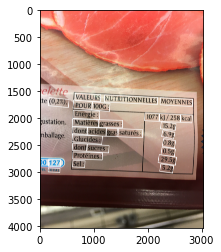

In [1032]:
plt.imshow(img)

In [1033]:
off_image.ocr[:5]

[Word: LOCAL, Bounding Box: [{'x': 152, 'y': 2920}, {'x': 370, 'y': 2931}, {'x': 366, 'y': 3004}, {'x': 148, 'y': 2993}], not included,
 Word: (0,2%),, Bounding Box: [{'x': 167, 'y': 1618}, {'x': 536, 'y': 1654}, {'x': 522, 'y': 1804}, {'x': 152, 'y': 1768}], not included,
 Word: 127, Bounding Box: [{'x': 160, 'y': 2756}, {'x': 379, 'y': 2764}, {'x': 374, 'y': 2897}, {'x': 155, 'y': 2889}], not included,
 Word: |dont, Bounding Box: [{'x': 596, 'y': 2160}, {'x': 870, 'y': 2171}, {'x': 864, 'y': 2320}, {'x': 590, 'y': 2309}], included,
 Word: dont, Bounding Box: [{'x': 602, 'y': 2461}, {'x': 867, 'y': 2479}, {'x': 858, 'y': 2614}, {'x': 593, 'y': 2596}], included]

In [1034]:
off_image.rotate()

TypeError: Required argument 'scale' (pos 3) not found

In [1026]:
img = off_image.corrected_image.copy().astype(np.uint8)
for word_ocr in [x for x in off_image.ocr[:100] if x.included_in_nutrition_table]:
    cv2.polylines(img,
                        [np.array([[x['x'],x['y']] for x in word_ocr.relative_bounding_box])],
                        isClosed=True,color=(255,255,255),thickness=10,lineType = cv2.LINE_AA)

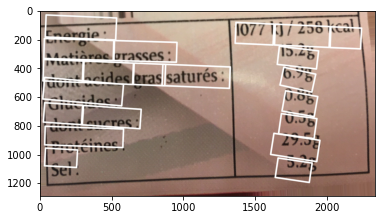

In [1017]:
plt.imshow(img)

In [984]:
off_image.get_image()
off_image.get_corrected_image()

AttributeError: 'OFFImage' object has no attribute 'get_corrected_image'

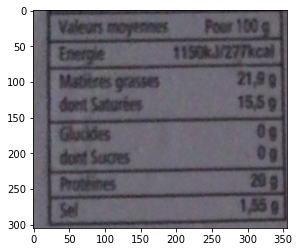

In [360]:
plt.imshow(off_image.corrected_image)

In [263]:
ocr = [x for x in convert_to_dict(df[df.barcode==3023260024781]['data'].iloc[0])['annotation']['textAnnotations'].values() if 'locale' not in x.keys()]

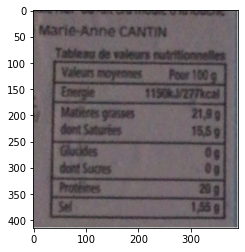

In [108]:
plt.imshow(off_image.get_image())

In [55]:
images = pd.read_csv('../../../../../../Projects/Open Food Facts/images.csv')

C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
images[images.barcode=='3023260024781']

,id,barcode,uploaded_at,image_id,source_image,width,height,deleted,server_domain,server_type
547883,856636,3023260024781,2017-12-26 17:46:30,1,/302/326/002/4781/1.jpg,1021,1360,f,api.openfoodfacts.org,off
547884,856637,3023260024781,2017-12-26 17:46:31,2,/302/326/002/4781/2.jpg,3024,4032,f,api.openfoodfacts.org,off
3187394,3274979,3023260024781,2020-06-22 16:44:46,3,/302/326/002/4781/3.jpg,391,415,f,api.openfoodfacts.org,off


In [57]:
len(images)

3303279

In [59]:
images.barcode.iloc[1]

'5400141167801'

,id,barcode,type,data,timestamp,completed_at,annotation,latent,countries,brands,...,value_tag,value,source_image,automatic_processing,server_domain,server_type,unique_scans_n,reserved_barcode,predictor,username
24,95d4859c-3c05-408e-b665-fbd4e1a8f76f,3023260024781,nutrition_table_structure,"{'annotation': {'crop': {'end': {'x': 371, 'y'...",2020-10-16T13:07:24.235714,2020-10-30T14:15:33.501048,1,False,NaN,NaN,...,NaN,NaN,/302/326/002/4781/3.jpg,False,api.openfoodfacts.org,off,0,False,NaN,NaN


In [826]:
import nltk

ModuleNotFoundError: No module named 'nltk'